# Gaussian Mixture Model clustering of all COI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
# export
from ehv import core, load as e_load, correlation
from matplotlib import cm
import matplotlib
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [4]:
samples = None
# samples = pandas.read_csv("data/selected_samples.csv")
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

df = df[df["meta_label_coi"]]
df.shape

import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [88]:
projection = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ica/Low/6ffc299f-fcd6-497f-9632-9b5c0656426f.dat")
projection.shape

(339045, 4)

In [89]:
model = GaussianMixture(n_components=10, covariance_type="diag", random_state=42, max_iter=1000)

In [90]:
%%time
model.fit(projection)

CPU times: user 14.3 s, sys: 16.4 s, total: 30.8 s
Wall time: 3.9 s


GaussianMixture(covariance_type='diag', max_iter=1000, n_components=10,
                random_state=42)

In [91]:
model.n_iter_

15

In [92]:
model.means_[0]

array([ 0.00395793, -0.00014525, -0.00061887, -0.0003157 ])

In [93]:
model.covariances_[0]

array([7.27285780e-06, 2.79758892e-06, 5.63301246e-06, 1.51184446e-06])

In [94]:
model.lower_bound_

20.664407738418202

In [95]:
df["meta_bgmm_label"] = model.predict(projection)

In [96]:
len(df["meta_bgmm_label"].unique())

10

In [17]:
umap_projection = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/c8ba196c-0b22-4489-9f9c-1242f68dd7a5.dat")
for i in range(umap_projection.shape[1]):
    df["dim_%d" % (i+1)] = umap_projection[:, i]

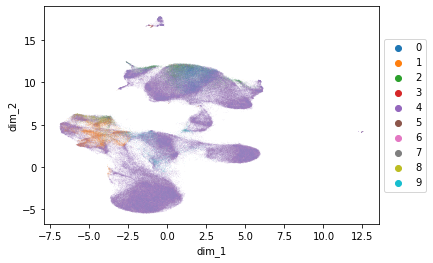

In [97]:
ax = seaborn.scatterplot(
    data=df[df["meta_label"] != "unknown"], 
    x="dim_1", y="dim_2", hue="meta_bgmm_label", 
    edgecolors="none", s=0.1, alpha=0.5, legend=True,
    palette=seaborn.color_palette(n_colors=len(df["meta_bgmm_label"].unique()))
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/fbc5bd36-0ba8-44d0-b526-654873c0b4e0.jpg")